<a href="https://colab.research.google.com/github/nicholashagemann/lambdalectures/blob/main/DS29_GP_Unit2_Sprint3_Module4_Nivi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OVERVIEW

1. Announcements
2. Sample code for data imbalance
3. Work on a regression model 
4. Learn about PDP and SHAP plots
5. Talk about project module and SC

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**

# I. Wrangle Data

In [ ]:
import pandas as pd

In [ ]:
def wrangle(filepath):
  df = pd.read_csv(filepath,skipinitialspace=True, parse_dates=['issue_d'], index_col = 'issue_d').sort_index()

  # taking int_rate as our target variable, remove the percentage symbol and convert to float
  # Use the strip function or replace function
  df['int_rate'] = df['int_rate'].str.strip('%').astype(float)

  # Consider only a subset where the term is 36 months
  df = df[df['term'] == '36 months']
  df.drop(columns = 'term', inplace = True)

  # Use regex to consolidate values in a feature
  keywords = ['business', 'consolidation|credit', 'home', 'car|vacation|medical|moving']
  for col in keywords:
    df[col] = (df['title']
              .fillna('')
              .str.lower()
              .str.contains(col,  regex=True)
              .astype(int))
    
  # Subset of the data / columns to retain
  keep_cols = keywords + ['annual_inc', 'fico_range_high', 
                          'funded_amnt', 'int_rate']
  df = df[keep_cols]
  return df

df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')

In [ ]:
df.head()

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,fico_range_high,funded_amnt,int_rate
issue_d,,,,,,,,
2007-07-01,0,0,0,0,20000.0,684.0,3500.0,10.28
2007-07-01,0,0,0,0,95000.0,774.0,5000.0,7.43
2007-07-01,0,0,0,0,150000.0,779.0,5000.0,7.43
2007-07-01,0,0,0,0,200000.0,679.0,3000.0,10.28
2007-08-01,0,0,0,0,61800.0,749.0,4000.0,7.75


columns with same values but different typecase.

In [ ]:
df.tail()

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,fico_range_high,funded_amnt,int_rate
issue_d,,,,,,,,
2019-03-01,0,0,0,0,91800.0,674.0,6500.0,11.71
2019-03-01,0,1,0,0,43000.0,714.0,6000.0,28.80
2019-03-01,0,1,0,0,47000.0,724.0,12000.0,11.71
2019-03-01,0,1,0,0,75000.0,709.0,20500.0,11.71
2019-03-01,0,1,0,0,96000.0,674.0,5000.0,8.19


# II. Split Data

In [ ]:
target = 'int_rate'
y = df[target]
X = df.drop(columns = target)

In [ ]:
X.shape

(102996, 7)

In [ ]:
# Split data into training, validation and test in sequence
#X_train, y_train = 
X_train, y_train = X[:-20000], y[:-20000]
X_val, y_val = X[-20000:-10000], y[-20000:-10000]
X_test, y_test = X.tail(10000),y.tail(10000)
#X_test,y_test = X[-10000:], y[-10000:]

In [ ]:
X_train

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,fico_range_high,funded_amnt
issue_d,,,,,,,
2007-07-01,0,0,0,0,20000.0,684.0,3500.0
2007-07-01,0,0,0,0,95000.0,774.0,5000.0
2007-07-01,0,0,0,0,150000.0,779.0,5000.0
2007-07-01,0,0,0,0,200000.0,679.0,3000.0
2007-08-01,0,0,0,0,61800.0,749.0,4000.0
...,...,...,...,...,...,...,...
2016-12-01,0,0,0,0,110000.0,724.0,6025.0
2016-12-01,0,1,0,0,43000.0,664.0,4800.0
2016-12-01,0,1,0,0,53200.0,674.0,5000.0


# III. Establish Baseline

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
y_bl_pred = [y_train.mean()] * len(y_train)
print('Mean interest rate:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train,y_bl_pred))

Mean interest rate: 11.559685527011519
Baseline MAE: 2.8988644656906475


# IV. Build Model

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
model_r = Ridge()
model_rfr = RandomForestRegressor()
model_xgbr = XGBRegressor()

In [ ]:
model_r.fit(X_train,y_train)
model_rfr.fit(X_train,y_train)
model_xgbr.fit(X_train,y_train)

[23:48:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# V. Check Metrics

In [ ]:
def check_metrics(model):
  print(model)
  print('TRaining MAE', mean_absolute_error(y_train,model.predict(X_train)))
  print('Validation MAE', mean_absolute_error(y_val,model.predict(X_val)))
  print('Validation R2', model.score(X_val,y_val))
  #print('Validation R2', model.r2_score(model.predict(X_val),y_val))

model = [model_r,model_rfr, model_xgbr]

for m in model:
  check_metrics(m)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
TRaining MAE 2.3998616385044973
Validation MAE 2.6447705604356764
Validation R2 0.22255361069312085
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
TRaining MAE 1.1505192019260004
Validation MAE 2.774860269960257
Validation R2 0.13910566172041805
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', lear

# VI. Communicate Results

## Partial Dependence Plots

One Feature

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [ ]:
X_val.columns

Index(['business', 'consolidation|credit', 'home',
       'car|vacation|medical|moving', 'annual_inc', 'fico_range_high',
       'funded_amnt'],
      dtype='object')

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f03b8be9990>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f03ba116250>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


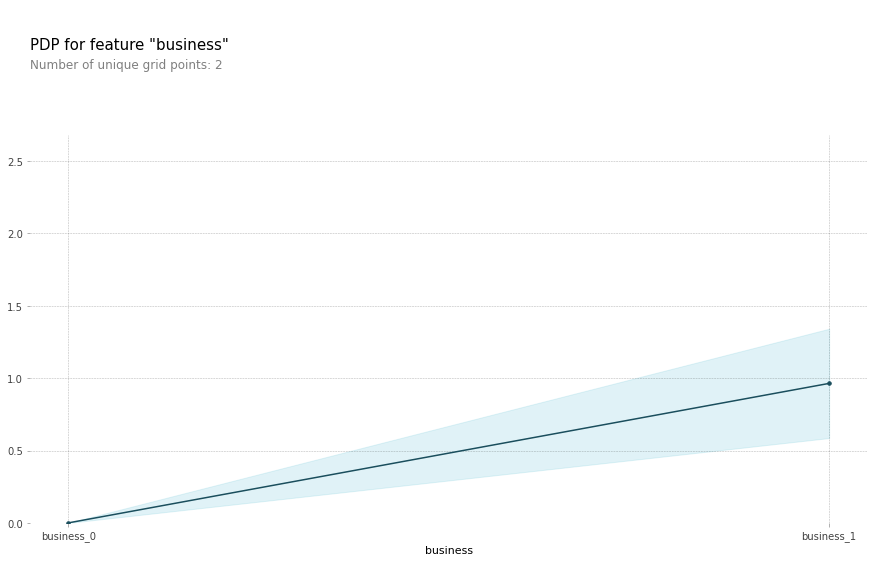

In [ ]:
isolate = pdp_isolate(model_xgbr,
                      dataset = X_val,
                      model_features = X_val.columns,
                      feature = 'business')

pdp_plot(isolate,feature_name = 'business')

Two features

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f03ba8a8050>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f03ba116f10>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


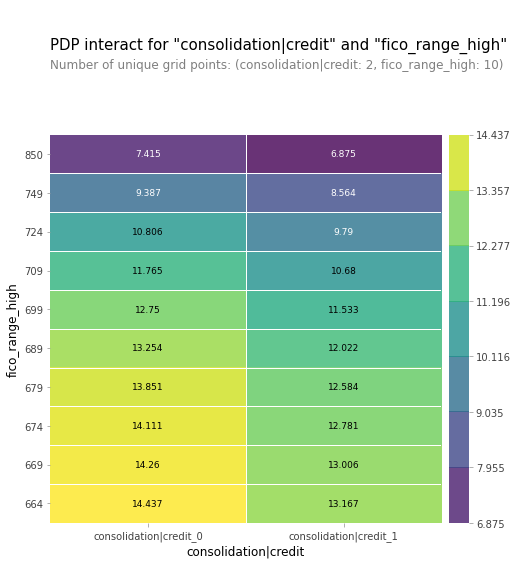

In [ ]:
features = ['consolidation|credit','fico_range_high']
interact = pdp_interact(model_xgbr,
                        dataset = X_val,
                        model_features = X_val.columns,
                        features=features)

pdp_interact_plot(interact,plot_type='grid',feature_names = features)

## Shapley Plots

- Show you the influence of features in *individual* predictions.

In [ ]:
import shap

In [ ]:
samp = X_val.tail(1)
samp

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,fico_range_high,funded_amnt
issue_d,,,,,,,
2017-08-01,0,1,0,0,38000.0,739.0,7000.0


In [ ]:
explainer = shap.TreeExplainer(model_xgbr) # SHAP DOESNT NOT TAKE IN PIPELINES
shap_values = explainer.shap_values(samp)

shap.initjs()
shap.force_plot(base_value=explainer.expected_value,
                shap_values = shap_values, 
                features=samp)


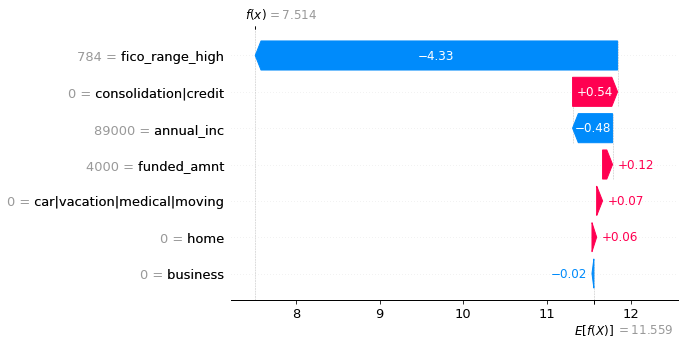

In [ ]:
explainer=shap.TreeExplainer(model_xgbr)
shap_values=explainer(X_val)
shap.plots.waterfall(shap_values[0])